https://www.geeksforgeeks.org/epsilon-greedy-algorithm-in-reinforcement-learning/
https://github.com/ShangtongZhang/reinforcement-learning-an-introduction/tree/master/chapter02

## 问题定义

一个n臂的老虎机(`n-Armed Bandit`)定义为如下形式：

1. 智能体有$n$个可以重复选择的动作。
2. 每次选择了某个动作之后，将会从一个固定的分布中获取奖励。
3. 智能体的目标是在给定的决策次数下最大化总的能够获得的收益。


每个动作都会有一个期望奖励，或者称之为平均奖励，我们将这个值称之为这个动作的值(`value`)，但是对于智能体来说，其并不知道这个值是多少，只能不断地去试。因此这里会有一个探索和利用的问题(exploration和exploitation)，也就是说要去探索，是否会有比当前的action更好的action。

真实的动作值函数为$q$，在第$t$个时间步对动作$a$的估计称之为$Q(a)$，用公式可以表示为：

$$
Q_{t}(a)=\frac{R_{1}+R_{2}+\cdots+R_{N_{t}(a)}}{N_{t}(a)}
$$

其中$N$表示选择了$a$这个动作$N$次。

如果是贪婪地做决策的话，每次选择的动作为：

$$
A_{t}=\underset{a}{\operatorname{argmax}} Q_{t}(a)
$$

也就是选择能够获得最大$Q_{t}$的那个对应的动作$a$。但是这样就没有探索了，因此提出了一种$\epsilon$-greedy策略，大多数时候是选择能够获取最大$Q$值对应的那个动作，而以$\epsilon$的概率随机选择动作。如果$\epsilon = 0$那么就是纯贪婪策略了。

## 多臂老虎机奖励分布

假设我们有十个多臂老虎机，每个臂的均值为$q_{*}(A_{t})$，方差为1，则其即时奖励分布可以表示为：

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def figure_2_1():
    plt.violinplot(dataset=np.random.randn(200, 10) + np.random.randn(10))
    plt.xlabel('Action')
    plt.ylabel("Reward distribution")
    plt.show()
    plt.close()
    
figure_2_1()

## 定义一个Bandit类

### $\epsilon$-greedy多臂老虎机

对于$\epsilon$-greedy多臂老虎机需要传入的参数有$\epsilon$这个超参数，arm的个数，含有的方法有三个：

1. reset初始化bandit。
2. act选择最优的arm。
3. step更新q估计。

这里采用平均奖励更新Q估计。但是如果记录每次选择的每个臂的奖励，然后每次都求平均的话，计算开销就会有点大，因此这里采用增量式的更新公式：

$$
\begin{aligned}
Q_{k+1} &=\frac{1}{k} \sum_{i}^{k} R_{i} \\
&=\frac{1}{k}\left(R_{k}+\sum_{i=1}^{k-1} R_{i}\right) \\
&=\vdots \\
&=Q_{k}+\frac{1}{k}\left[R_{k}-Q_{k}\right]
\end{aligned}
$$

更一般的表示可以表示为：

$$
NewEstimate ← OldEstimate + StepSize [Target − OldEstimate]
$$

在这里$StepSize = \frac{1}{k}$, 不过选用$\frac{1}{k}$的时候，这个步长是会随着时间变化的。

In [ ]:
class GreedyBandit:
    def __init__(self, k_arm=10, epsilon=0.):
        self.k = k_arm
        self.indices = np.arange(self.k)
        self.time = 0
        self.epsilon = epsilon

    def reset(self):
        # real reward for each action
        self.q_true = np.random.randn(self.k)
        # 初始化每个动作的初始估计都为0。
        self.q_estimation = np.zeros(self.k)

        # 每个动作的选择次数初始时都为0。
        self.action_count = np.zeros(self.k)

        self.best_action = np.argmax(self.q_true)

        self.time = 0

    # get an action for this bandit
    def act(self):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.indices)
        
        q_best = np.max(self.q_estimation)
        return np.random.choice(np.where(self.q_estimation == q_best)[0])

    # take an action, update estimation for this action
    def step(self, action):
        # 基于正太分布N(real reward, 1)生成奖励。
        reward = np.random.randn() + self.q_true[action]
        self.time += 1
        self.action_count[action] += 1

        # 更新Q估计：NewEstimate ← OldEstimate + StepSize [Target − OldEstimate]
        self.q_estimation[action] += (reward - self.q_estimation[action]) / self.action_count[action]
        
        return reward

In [ ]:
from tqdm import trange
def simulate(runs, time, bandits):
    """
    给定回合数，训练次数和bandits进行仿真
    """
    rewards = np.zeros((len(bandits), runs, time))
    best_action_counts = np.zeros(rewards.shape)
    for i, bandit in enumerate(bandits):
        for r in trange(runs):
            bandit.reset()
            for t in range(time):
                action = bandit.act()
                reward = bandit.step(action)
                rewards[i, r, t] = reward
                if action == bandit.best_action:
                    best_action_counts[i, r, t] = 1
    # axis=1表示在每个时间步下，所有的回合对应时间步获得的奖励和最优动作选择次数的和。
    mean_best_action_counts = best_action_counts.mean(axis=1)
    mean_rewards = rewards.mean(axis=1)
    return mean_best_action_counts, mean_rewards

In [ ]:
def figure_2_2(runs=2000, time=1000):
    epsilons = [0, 0.1, 0.01]
    bandits = [GreedyBandit(epsilon=eps) for eps in epsilons]
    best_action_counts, rewards = simulate(runs, time, bandits)

    plt.figure(figsize=(10, 20))

    plt.subplot(2, 1, 1)
    for eps, rewards in zip(epsilons, rewards):
        plt.plot(rewards, label='$\epsilon = %.02f$' % (eps))
    plt.xlabel('steps')
    plt.ylabel('average reward')
    plt.legend()

    plt.subplot(2, 1, 2)
    for eps, counts in zip(epsilons, best_action_counts):
        plt.plot(counts, label='$\epsilon = %.02f$' % (eps))
    plt.xlabel('steps')
    plt.ylabel('% optimal action')
    plt.legend()
    
    plt.show()
    
    plt.close()
    
figure_2_2()

这里需要讨论一下StepSize这个问题，如果取平均，也就是$\frac{1}{k}$的时候，对于平稳的强化学习问题来说是可以的，但是对于非平稳的强化学习问题就会有问题。非平稳的强化学习问题说的是奖励的分布会随着时间发生改变，此时给近期获得的即使奖励一个较高的权重，而对于过去的及时收益赋予较低的权重，然后将二者加权求和，就是现在强化学习用的方法。

具体实现就是将这个StepSize设置为一个固定的常数$\alpha$。

此时更新公式展开可以表示为：

$$
\begin{aligned}
Q_{k+1} &=Q_{k}+\alpha\left[R_{k}-Q_{k}\right] \\
&=\alpha R_{k}+(1-\alpha) Q_{k} \\
&=\alpha R_{k}+(1-\alpha)\left[\alpha R_{k-1}+(1-\alpha) Q_{k-1}\right] \\
&=\alpha R_{k}+(1-\alpha) \alpha R_{k-1}+(1-\alpha)^{2} Q_{k-1} \\
&=\vdots \\
&=(1-\alpha)^{k} Q_{1}+\sum_{i}^{k} \alpha(1-\alpha)^{k-i} R_{i}
\end{aligned}
$$

可以看到，比较靠近当前时刻$k+1$的奖励被赋予的权重会比较大，越往前，权重会越小。而两者的系数求和会等于1。但是收敛性是没有办法像其值等于$\frac{1}{k}$那样得到保证的。

## 乐观(Optimistic)初始化

因为对于初始估计Q值的初始化时人为给定的，所以是一个有偏估计。

对于之前的bandit问题，其奖励均值为0，方差为1，因此，如果设置初始估计值为+5的话，对于智能体来说是鼓励探索的。

但是对于非平稳性问题，这种探索是暂时的。

In [ ]:
class OptimisticBandit:

    def __init__(self, k_arm=10, epsilon=0., initial=0., step_size=0.1):
        self.k = k_arm
        self.step_size = step_size
        self.indices = np.arange(self.k)

        self.epsilon = epsilon
        self.initial = initial

    def reset(self):
        # real reward for each action
        self.q_true = np.random.randn(self.k) #+ self.true_reward

        # estimation for each action
        self.q_estimation = np.zeros(self.k) + self.initial

        self.best_action = np.argmax(self.q_true)

    def act(self):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.indices)

        q_best = np.max(self.q_estimation)
        return np.random.choice(np.where(self.q_estimation == q_best)[0])

    # take an action, update estimation for this action
    def step(self, action):
        # generate the reward under N(real reward, 1)
        reward = np.random.randn() + self.q_true[action]

        # 基于固定步长更新Q估计
        self.q_estimation[action] += self.step_size * (reward - self.q_estimation[action])
        return reward

In [ ]:
def figure_2_3(runs=2000, time=1000):
    bandits = []
    bandits.append(OptimisticBandit(epsilon=0, initial=5, step_size=0.1))
    bandits.append(OptimisticBandit(epsilon=0.1, initial=0, step_size=0.1))
    best_action_counts, _ = simulate(runs, time, bandits)

    plt.plot(best_action_counts[0], label='$\epsilon = 0, q = 5$')
    plt.plot(best_action_counts[1], label='$\epsilon = 0.1, q = 0$')
    plt.xlabel('Steps')
    plt.ylabel('% optimal action')
    plt.legend()

    plt.show()
    plt.close()
figure_2_3()

### UCB

贪心的方法是随机地选择探索的动作，而有没有一种办法来量化这种选择最优动作和探索动作呢？这就是UCB的计算公式：

$$
A_{t}=\underset{a}{\operatorname{argmax}}\left[Q_{t}(a)+c \sqrt{\frac{\ln t}{N_{t}(a)}}\right]
$$

其中$c$是UCB的参数。

In [ ]:
class UcbBandit:
    def __init__(self, k_arm=10, epsilon=0., initial=0., UCB_param=None):
        self.k = k_arm
        self.indices = np.arange(self.k)
        self.UCB_param = UCB_param
        self.epsilon = epsilon
        self.initial = initial

    def reset(self):
        # real reward for each action
        self.q_true = np.random.randn(self.k) # + self.true_reward

        # estimation for each action
        self.q_estimation = np.zeros(self.k) # + self.initial

        # # of chosen times for each action
        self.action_count = np.zeros(self.k)

        self.best_action = np.argmax(self.q_true)

        self.time = 0

    # get an action for this bandit
    def act(self):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.indices)

        UCB_estimation = self.q_estimation + self.UCB_param * np.sqrt(np.log(self.time + 1) / (self.action_count + 1e-5))
        q_best = np.max(UCB_estimation)
        return np.random.choice(np.where(UCB_estimation == q_best)[0])


    # take an action, update estimation for this action
    def step(self, action):
        # generate the reward under N(real reward, 1)
        reward = np.random.randn() + self.q_true[action]
        self.time += 1
        self.action_count[action] += 1

        self.q_estimation[action] += (reward - self.q_estimation[action]) / self.action_count[action]
        return reward

In [ ]:
def figure_2_4(runs=2000, time=1000):
    bandits = []
    bandits.append(UcbBandit(epsilon=0, UCB_param=2))
    bandits.append(GreedyBandit(epsilon=0.1))
    _, average_rewards = simulate(runs, time, bandits)

    plt.plot(average_rewards[0], label='UCB $c = 2$')
    plt.plot(average_rewards[1], label='epsilon greedy $\epsilon = 0.1$')
    plt.xlabel('Steps')
    plt.ylabel('Average reward')
    plt.legend()

    plt.show()
    plt.close()
figure_2_4()

### 梯度赌博算法

梯度多臂老虎机算法的动作选择公式为：

$$
\operatorname{Pr}\left\{A_{t}=a\right\} \doteq \frac{e^{H_{t}(a)}}{\sum_{b=1}^{k} e^{H_{t}(b)}} \doteq \pi_{t}(a)
$$

更新公式为：

$$
\begin{aligned}
H_{t+1}\left(A_{t}\right) & \doteq H_{t}\left(A_{t}\right)+\alpha\left(R_{t}-\bar{R}_{t}\right)\left(1-\pi_{t}\left(A_{t}\right)\right), & & \text { and } \\
H_{t+1}(a) & \doteq H_{t}(a)-\alpha\left(R_{t}-\bar{R}_{t}\right) \pi_{t}(a), & \text { for all } a \neq A_{t}
\end{aligned}
$$

当$t$时刻选择动作$A_{t}$时，如果得到的实时奖励$R_{t}$远远超过平均奖励$ \bar{R}_{t}$，即${R}_{t} >> \bar{R}_{t}$ ，而$\pi_{t}\left(A_{t}\right)<< 1$ ，因此在$t+1$时刻，一定会增加对动作$A_{t}$的偏好，因为实际得到的奖励远超平均嘛。而对于其他没有选择的动作，则会根据这个差值 $R_{t}-\bar{R}_{t}$ 向反方向变化，即削弱对其他动作的偏好。

- https://zhuanlan.zhihu.com/p/87446969

In [ ]:
class GradientBandit:
    def __init__(self, k_arm=10, epsilon=0., step_size=0.1, gradient=False, gradient_baseline=False, true_reward=0.):
        self.k = k_arm
        self.step_size = step_size
        self.indices = np.arange(self.k)
        self.time = 0
        self.gradient = gradient
        self.gradient_baseline = gradient_baseline
        self.average_reward = 0
        self.true_reward = true_reward
        self.epsilon = epsilon

    def reset(self):
        # real reward for each action
        self.q_true = np.random.randn(self.k) + self.true_reward

        # estimation for each action
        self.q_estimation = np.zeros(self.k)

        self.best_action = np.argmax(self.q_true)

        self.time = 0

    # get an action for this bandit
    def act(self):
        exp_est = np.exp(self.q_estimation)
        self.action_prob = exp_est / np.sum(exp_est)
        return np.random.choice(self.indices, p=self.action_prob)

    # take an action, update estimation for this action
    def step(self, action):
        # generate the reward under N(real reward, 1)
        reward = np.random.randn() + self.q_true[action]
        self.time += 1
#         self.action_count[action] += 1
        self.average_reward += (reward - self.average_reward) / self.time

        one_hot = np.zeros(self.k)
        one_hot[action] = 1
        if self.gradient_baseline:
            baseline = self.average_reward
        else:
            baseline = 0
        self.q_estimation += self.step_size * (reward - baseline) * (one_hot - self.action_prob)
        return reward

In [ ]:
def figure_2_5(runs=2000, time=1000):
    bandits = []
    bandits.append(GradientBandit(gradient=True, step_size=0.1, gradient_baseline=True, true_reward=4))
    bandits.append(GradientBandit(gradient=True, step_size=0.1, gradient_baseline=False, true_reward=4))
    bandits.append(GradientBandit(gradient=True, step_size=0.4, gradient_baseline=True, true_reward=4))
    bandits.append(GradientBandit(gradient=True, step_size=0.4, gradient_baseline=False, true_reward=4))
    best_action_counts, _ = simulate(runs, time, bandits)
    labels = [r'$\alpha = 0.1$, with baseline',
              r'$\alpha = 0.1$, without baseline',
              r'$\alpha = 0.4$, with baseline',
              r'$\alpha = 0.4$, without baseline']

    for i in range(len(bandits)):
        plt.plot(best_action_counts[i], label=labels[i])
    plt.xlabel('Steps')
    plt.ylabel('% Optimal action')
    plt.legend()

    plt.show()
    plt.close()
figure_2_5()

## 总结

In [ ]:
class Bandit:
    # @k_arm: # of arms
    # @epsilon: probability for exploration in epsilon-greedy algorithm
    # @initial: initial estimation for each action
    # @step_size: constant step size for updating estimations
    # @sample_averages: if True, use sample averages to update estimations instead of constant step size
    # @UCB_param: if not None, use UCB algorithm to select action
    # @gradient: if True, use gradient based bandit algorithm
    # @gradient_baseline: if True, use average reward as baseline for gradient based bandit algorithm
    def __init__(self, k_arm=10, epsilon=0., initial=0., step_size=0.1, sample_averages=False, UCB_param=None,
                 gradient=False, gradient_baseline=False, true_reward=0.):
        self.k = k_arm
        self.step_size = step_size
        self.sample_averages = sample_averages
        self.indices = np.arange(self.k)
        self.time = 0
        self.UCB_param = UCB_param
        self.gradient = gradient
        self.gradient_baseline = gradient_baseline
        self.average_reward = 0
        self.true_reward = true_reward
        self.epsilon = epsilon
        self.initial = initial

    def reset(self):
        # real reward for each action
        self.q_true = np.random.randn(self.k) + self.true_reward

        # estimation for each action
        self.q_estimation = np.zeros(self.k) + self.initial

        # # of chosen times for each action
        self.action_count = np.zeros(self.k)

        self.best_action = np.argmax(self.q_true)

        self.time = 0

    # get an action for this bandit
    def act(self):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.indices)

        if self.UCB_param is not None:
            UCB_estimation = self.q_estimation + \
                self.UCB_param * np.sqrt(np.log(self.time + 1) / (self.action_count + 1e-5))
            q_best = np.max(UCB_estimation)
            return np.random.choice(np.where(UCB_estimation == q_best)[0])

        if self.gradient:
            exp_est = np.exp(self.q_estimation)
            self.action_prob = exp_est / np.sum(exp_est)
            return np.random.choice(self.indices, p=self.action_prob)

        q_best = np.max(self.q_estimation)
        return np.random.choice(np.where(self.q_estimation == q_best)[0])

    # take an action, update estimation for this action
    def step(self, action):
        # generate the reward under N(real reward, 1)
        reward = np.random.randn() + self.q_true[action]
        self.time += 1
        self.action_count[action] += 1
        self.average_reward += (reward - self.average_reward) / self.time

        if self.sample_averages:
            # update estimation using sample averages
            self.q_estimation[action] += (reward - self.q_estimation[action]) / self.action_count[action]
        elif self.gradient:
            one_hot = np.zeros(self.k)
            one_hot[action] = 1
            if self.gradient_baseline:
                baseline = self.average_reward
            else:
                baseline = 0
            self.q_estimation += self.step_size * (reward - baseline) * (one_hot - self.action_prob)
        else:
            # update estimation with constant step size
            self.q_estimation[action] += self.step_size * (reward - self.q_estimation[action])
        return reward

In [ ]:
def figure_2_6(runs=2000, time=1000):
    labels = ['epsilon-greedy', 'gradient bandit',
              'UCB', 'optimistic initialization']
    generators = [lambda epsilon: Bandit(epsilon=epsilon, sample_averages=True),
                  lambda alpha: Bandit(gradient=True, step_size=alpha, gradient_baseline=True),
                  lambda coef: Bandit(epsilon=0, UCB_param=coef, sample_averages=True),
                  lambda initial: Bandit(epsilon=0, initial=initial, step_size=0.1)]
    parameters = [np.arange(-7, -1, dtype=np.float),
                  np.arange(-5, 2, dtype=np.float),
                  np.arange(-4, 3, dtype=np.float),
                  np.arange(-2, 3, dtype=np.float)]

    bandits = []
    for generator, parameter in zip(generators, parameters):
        for param in parameter:
            bandits.append(generator(pow(2, param)))

    _, average_rewards = simulate(runs, time, bandits)
    rewards = np.mean(average_rewards, axis=1)

    i = 0
    for label, parameter in zip(labels, parameters):
        l = len(parameter)
        plt.plot(parameter, rewards[i:i+l], label=label)
        i += l
    plt.xlabel('Parameter($2^x$)')
    plt.ylabel('Average reward')
    plt.legend()

    plt.show()
    plt.close()
figure_2_6()

## 将bandit环境封装

采用`gym`中类似的方法将`bandit`环境封装起来。

In [1]:
import gym
import numpy as np
from gym import spaces
import matplotlib.pyplot as plt

In [7]:
from typing import List
class BanditEnv(gym.Env):
    def __init__(self, num_bandits, reward_list):
        assert len(reward_list) == num_bandits, "The reward list not eql to num_bandits."
        assert isinstance(reward_list, list), "The type of reward list not eql to List."
        
        self.action_space = spaces.Discrete(num_bandits)  # 动作空间为num bandits的数量。
        self.reward_list = reward_list  # 奖励list
    
    def step(self, action):
        reward = self.reward_list[action] + 0.1 * np.random.randn()
        return reward

In [8]:
class GreedyAgent(object):
    def __init__(self, env, epsilon):
        self.env = env
        self.bandit_nums = env.action_space.n # bandit的个数
        self.epsilon = epsilon  
        self.vis_count = np.zeros(self.bandit_nums)  # 记录每个bandit的访问次数
        self.reward_estimation = np.zeros(self.bandit_nums)  # 对
    
    def choose_action(self):
        if np.random.randn() < self.epsilon:
            action = np.random.choice(self.bandit_nums)
        else:
            action = np.argmax(self.reward_estimation)
        
        reward = self.env.step(action)
        return action, reward
    
    def update_agent(self, reward, action):
        self.vis_count[action] += 1
        self.reward_estimation[action] = (1 - 1.0/self.vis_count[action])*self.reward_estimation[action] + 1.0/self.vis_count[action]*reward

In [9]:
def run(m1, m2, m3, eps, N):
    bandits = BanditEnv(num_bandits = 3, reward_list = [m1, m2, m3])
    agent = GreedyAgent(bandits, eps)
    data = np.empty(N)
    for i in range(N):
        action, reward = agent.choose_action()
        agent.update_agent(reward, action)
        
        data[i] = reward
    
    cumulative_average = np.cumsum(data) / (np.arange(N) + 1)
    
    plt.plot(cumulative_average)
    plt.plot(np.ones(N)*m1)
    plt.plot(np.ones(N)*m2)
    plt.plot(np.ones(N)*m3)
    plt.xscale('log')
    plt.show()
    
    for mean_reward in bandits.reward_list:
        print(mean_reward)
  
    return cumulative_average

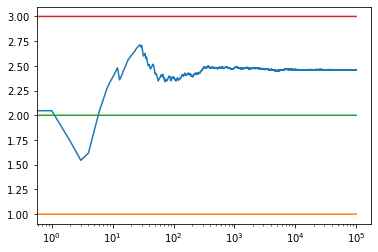

1.0
2.0
3.0


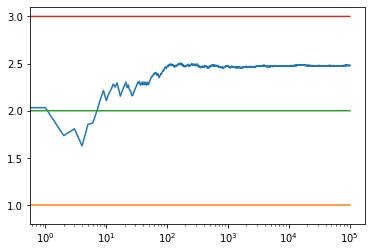

1.0
2.0
3.0


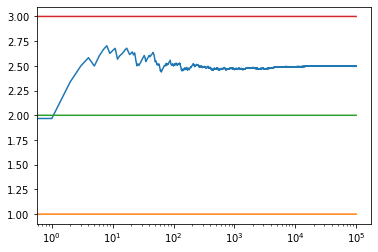

1.0
2.0
3.0


In [10]:
c_1 = run(1.0, 2.0, 3.0, 0.1, 100000)
c_05 = run(1.0, 2.0, 3.0, 0.05, 100000)
c_01 = run(1.0, 2.0, 3.0, 0.01, 100000)

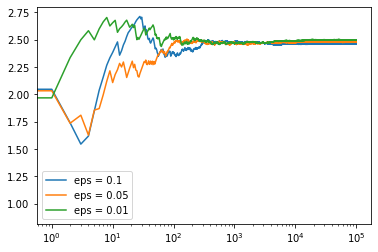

In [11]:
# log scale plot
plt.plot(c_1, label ='eps = 0.1')
plt.plot(c_05, label ='eps = 0.05')
plt.plot(c_01, label ='eps = 0.01')
plt.legend()
plt.xscale('log')
plt.show()